In [86]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By 
import matplotlib.pyplot as plt
import time

In [87]:
base_url = "https://nextspaceflight.com/launches/past/"
last_page = 1 #tiene 239


In [88]:
#Para que no se abra el navegador cada vez
from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument("--headless")  # Ejecutar en modo headless (sin abrir una ventana del navegador)


###

browser = webdriver.Chrome(options=options) # generamos un navegador automatizado


#Diccionario
launch_data = []

for page in range(1, last_page + 1):  #Recorrer Paginas
    browser.get(f"{base_url}?page={page}") # obtenemos el html (hace la petición) #Generaliza Scrapping para todas las pgs del sitio
    cards = browser.find_elements(By.CLASS_NAME, "mdl-card")
    for card in cards:
        
        #Nombre Cohete - PayLoad
        rocket_and_payload = card.find_element(By.CLASS_NAME, "header-style").text  # type() -> string 
        
        #Compania Lanzadora
        company = card.find_element(By.CLASS_NAME, "mdl-card__title-text").text # type() -> string 
        
        #Fecha Lanzamiento y Locacion
        date_and_location = card.find_element(By.CLASS_NAME, "mdl-card__supporting-text").text  # type() -> string 
        
        #Link a Details
        details_url = card.find_element(By.CLASS_NAME, "mdc-button").get_attribute("href") # type() -> string
        
        # Ir al detalle
        browser.get(details_url)
        time.sleep(1)

        # === GENERALIZADO: tomar TODOS los pares "Label: Valor" del detalle ===
        details_dict = {}
        try:
            # Tomar todo el bloque de texto del detalle
            blocks = browser.find_elements(By.CLASS_NAME, "mdl-card__supporting-text")
            block_text = ""
            for b in blocks:
                t = b.get_attribute("innerText").strip()
                if "Price:" in t or "Status:" in t:
                    block_text = t
                    break

            if not block_text and blocks:
                block_text = max(blocks, key=lambda x: len(x.get_attribute("innerText"))).get_attribute("innerText")

            # Parsear todas las líneas con "Label: Value"
            lines = [ln.strip() for ln in block_text.splitlines() if ln.strip()]
            buffer_label = None
            for ln in lines:
                if ":" in ln:
                    label, value = ln.split(":", 1)
                    label = label.strip()
                    value = value.strip()
                    if label and value:
                        details_dict[label] = value
                        buffer_label = None
                    else:
                        buffer_label = label
                else:
                    if buffer_label:
                        prev = details_dict.get(buffer_label, "")
                        sep = " " if prev else ""
                        details_dict[buffer_label] = f"{prev}{sep}{ln}".strip()
        except:
            details_dict = {}

        # Volver a la lista
        browser.back()
        time.sleep(1)
        
        #Diccionario
        launch_dict = {'company': company, 
                    'rocket_and_payload': rocket_and_payload, 
                    'date_and_location': date_and_location, 
                    'details_url': details_url,}
        
        launch_dict.update(details_dict)
    
        launch_data.append(launch_dict)
    
browser.quit()

df = pd.DataFrame(launch_data) 

In [89]:
df.size #Multiplica filas x columnas
df.shape #Filas y columnas

(30, 14)

In [90]:
df.to_csv('launches.csv', index=False) # guardamos el dataframe en un csv para no repetir todo el scraping denuevo

# Generar columnas a partir de columnas existentes)
df["rocket"] = df["rocket_and_payload"].str.split("|").str[0] #Columna solo de Rocket
df["payload"] = df["rocket_and_payload"].str.split("|").str[1]
df["date"] = df["date_and_location"].str.split("GMT-4").str[0]
df["location"] = df["date_and_location"].str.split("GMT-4").str[1]
df.drop(columns=["rocket_and_payload", "date_and_location", "details_url"], inplace=True) #Eliminar columnas que no queremos


In [91]:
# Extraer el valor numérico de las columnas
df["Payload_LEO_numeric"] = (
    df["Payload to LEO"]
    .str.replace("kg", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
    .astype(float)
)

df["Payload_GTO_numeric"] = (
    df["Payload to GTO"]
    .str.replace("kg", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
    .replace("NaN", 0)  # Si tienes texto 'NaN', conviértelo a 0
    .fillna(0)           # Si tienes valores NaN reales, conviértelos a 0
    .astype(float)
)

# Sumar ambas columnas en una nueva
df["total_payload"] = df["Payload_LEO_numeric"] + df["Payload_GTO_numeric"]
# Eliminar las columnas originales y las numéricas, dejando solo 'total_payload' y las demás que quieras conservar
df.drop(columns=["Payload to LEO", "Payload to GTO", "Payload_LEO_numeric", "Payload_GTO_numeric"], inplace=True)
df

,company,Status,Price,Liftoff Thrust,Stages,Strap-ons,Rocket Height,Fairing Diameter,Fairing Height,rocket,payload,date,location,total_payload
0,Roscosmos,Active,$17.42 million,"4,550 kN",3,4,51.38 m,4.11 m,15.59 m,Soyuz 2.1a,Progress MS-32,"Thu Sep 11, 2025 12:54 GMT-3\nSite 31/6, Baiko...",NaN,7500.0
1,SpaceX,Active,$69.75 million,"7,607 kN",2,0,70.0 m,5.2 m,13.0 m,Falcon 9 Block 5,Tranche 1 Transport Layer B,"Wed Sep 10, 2025 11:12 GMT-3\nSLC-4E, Vandenbe...",NaN,31100.0
2,CASC,Active,NaN,"7,128 kN",3,4,58.0 m,4.2 m,12.4 m,Long March 7A,Yaogan 45,"Mon Sep 8, 2025 23:00 GMT-3\nLC-201, Wenchang ...",NaN,19000.0
3,Chinarocket,Active,NaN,NaN,4,0,31.0 m,3.35 m,NaN,Jielong 3,Geely Constellation Group 05,"Mon Sep 8, 2025 16:48 GMT-3\nOriental Spacepor...",NaN,1500.0
4,SpaceX,Active,$69.75 million,"7,607 kN",2,0,70.0 m,5.2 m,13.0 m,Falcon 9 Block 5,Starlink Group 17-9,"Sat Sep 6, 2025 2:06 PM","\nSLC-4E, Vandenberg SFB, California, USA",31100.0
5,CASC,Active,NaN,"7,230 kN",2,4,50.0 m,4.2 m,5.7 m,Long March 6A,Yaogan 40 Group 03,"Sat Sep 6, 2025 12:34 PM","\nLC-9A, Taiyuan Satellite Launch Center, China",5000.0
6,SpaceX,Active,$69.75 million,"7,607 kN",2,0,70.0 m,5.2 m,13.0 m,Falcon 9 Block 5,Starlink Group 10-57,"Fri Sep 5, 2025 8:32 AM","\nLC-39A, Kennedy Space Center, Florida, USA",31100.0
7,Galactic Energy,Active,$4.38 million,588 kN,4,0,19.0 m,1.4 m,2.5 m,Ceres 1,3 satellites,"Fri Sep 5, 2025 7:39 AM","\nSite 95A, Jiuquan Satellite Launch Center, C...",400.0
8,CASC,Active,$20.0 million,"5,923 kN",4,2,55.64 m,4.2 m,9.78 m,Long March 3C/YZ-1,Shiyan 29,"Thu Sep 4, 2025 10:34 PM","\nLC-2, Xichang Satellite Launch Center, China",11000.0
9,SpaceX,Active,$69.75 million,"7,607 kN",2,0,70.0 m,5.2 m,13.0 m,Falcon 9 Block 5,Starlink Group 10-22,"Wed Sep 3, 2025 7:56 AM","\nSLC-40, Cape Canaveral SFS, Florida, USA",31100.0


In [92]:
# definir función de limpieza de columna date 
# Dividir string de fechas

def clean_date(scraped_date_string):
    months = { "Jan":"01", "Feb":"02", "Mar":"03", "Apr":"04", "May":"05", "Jun":"06",
                "Jul":"07", "Aug":"08", "Sep":"09", "Oct":"10", "Nov":"11", "Dec":"12" }
    parts = scraped_date_string.split(" ")
    month = parts[1]
    day = parts[2].replace(",","")
    year = parts[3]
    return f"{year}/{months[month]}/{day}"

Data Frame

In [93]:
# limpiar columna date con .apply() de pandas
df["cleaned_date"] = df["date"].apply(clean_date)
df["year"] = df["cleaned_date"].str.split("/").str[0]
df["month"] = df["cleaned_date"].str.split("/").str[1]
df["day"] = df["cleaned_date"].str.split("/").str[2]
df.drop(columns=["date", "cleaned_date"], inplace=True)
df #Mostrar Data Frame

,company,Status,Price,Liftoff Thrust,Stages,Strap-ons,Rocket Height,Fairing Diameter,Fairing Height,rocket,payload,location,total_payload,year,month,day
0,Roscosmos,Active,$17.42 million,"4,550 kN",3,4,51.38 m,4.11 m,15.59 m,Soyuz 2.1a,Progress MS-32,NaN,7500.0,2025,09,11
1,SpaceX,Active,$69.75 million,"7,607 kN",2,0,70.0 m,5.2 m,13.0 m,Falcon 9 Block 5,Tranche 1 Transport Layer B,NaN,31100.0,2025,09,10
2,CASC,Active,NaN,"7,128 kN",3,4,58.0 m,4.2 m,12.4 m,Long March 7A,Yaogan 45,NaN,19000.0,2025,09,8
3,Chinarocket,Active,NaN,NaN,4,0,31.0 m,3.35 m,NaN,Jielong 3,Geely Constellation Group 05,NaN,1500.0,2025,09,8
4,SpaceX,Active,$69.75 million,"7,607 kN",2,0,70.0 m,5.2 m,13.0 m,Falcon 9 Block 5,Starlink Group 17-9,"\nSLC-4E, Vandenberg SFB, California, USA",31100.0,2025,09,6
5,CASC,Active,NaN,"7,230 kN",2,4,50.0 m,4.2 m,5.7 m,Long March 6A,Yaogan 40 Group 03,"\nLC-9A, Taiyuan Satellite Launch Center, China",5000.0,2025,09,6
6,SpaceX,Active,$69.75 million,"7,607 kN",2,0,70.0 m,5.2 m,13.0 m,Falcon 9 Block 5,Starlink Group 10-57,"\nLC-39A, Kennedy Space Center, Florida, USA",31100.0,2025,09,5
7,Galactic Energy,Active,$4.38 million,588 kN,4,0,19.0 m,1.4 m,2.5 m,Ceres 1,3 satellites,"\nSite 95A, Jiuquan Satellite Launch Center, C...",400.0,2025,09,5
8,CASC,Active,$20.0 million,"5,923 kN",4,2,55.64 m,4.2 m,9.78 m,Long March 3C/YZ-1,Shiyan 29,"\nLC-2, Xichang Satellite Launch Center, China",11000.0,2025,09,4
9,SpaceX,Active,$69.75 million,"7,607 kN",2,0,70.0 m,5.2 m,13.0 m,Falcon 9 Block 5,Starlink Group 10-22,"\nSLC-40, Cape Canaveral SFS, Florida, USA",31100.0,2025,09,3


Visualizacion de Datos

<Axes: xlabel='company'>

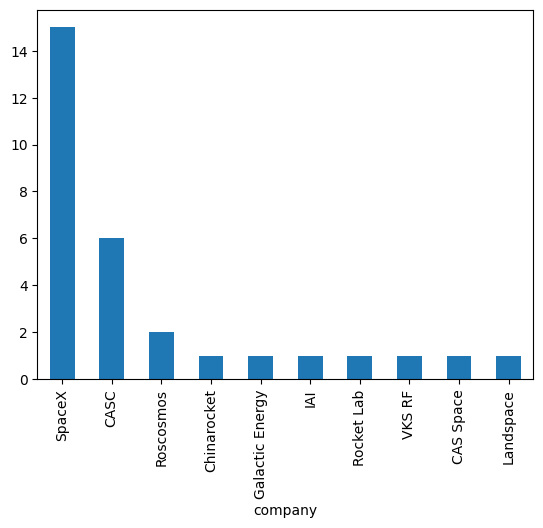

In [94]:
import matplotlib as plt

#Empresas que han enviado mas cargamento al espacio exitosamente
df["company"].value_counts().plot(kind="bar") 



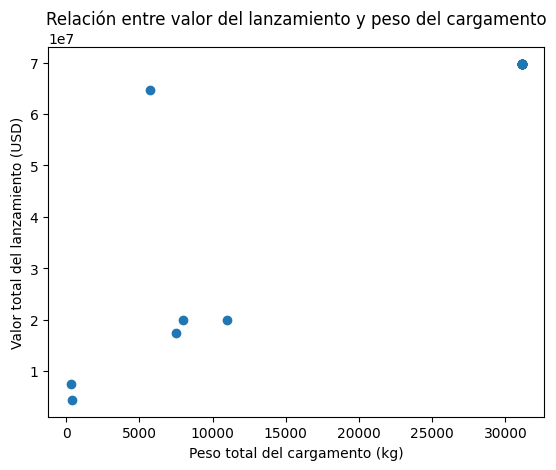

In [95]:
import matplotlib.pyplot as plt

# Asegúrate de que la columna 'Price' sea numérica (quita símbolos y convierte a float)
df["Price_numeric"] = (
    df["Price"]
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.replace("million", "", regex=False)
    .str.strip()
    .astype(float)
    * 1e6
)

# Graficar la relación entre precio y peso total
plt.scatter(df["total_payload"], df["Price_numeric"])
plt.xlabel("Peso total del cargamento (kg)")
plt.ylabel("Valor total del lanzamiento (USD)")
plt.title("Relación entre valor del lanzamiento y peso del cargamento")
plt.show()

In [96]:
import numpy as np

# Convertir columnas a numéricas (quita 'm', comas, espacios)
df["Fairing Diameter"] = df["Fairing Diameter"].str.replace("m", "", regex=False).str.replace(",", "", regex=False).str.strip().astype(float)
df["Fairing Height"] = df["Fairing Height"].str.replace("m", "", regex=False).str.replace(",", "", regex=False).str.strip().astype(float)

# Calcular volumen del carenado (cilindro)
df["Fairing Volume (m³)"] = np.pi * (df["Fairing Diameter"] / 2) ** 2 * df["Fairing Height"]

# Ver empresas con mayor volumen de carenado
empresas_volumen = df.groupby("company")["Fairing Volume (m³)"].max().sort_values(ascending=False)
print(empresas_volumen)

company
SpaceX             276.083162
Roscosmos          206.832909
CASC               171.794853
Landspace           44.070654
VKS RF              20.498892
IAI                  6.255166
Rocket Lab           4.580442
Galactic Energy      3.848451
CAS Space                 NaN
Chinarocket               NaN
Name: Fairing Volume (m³), dtype: float64


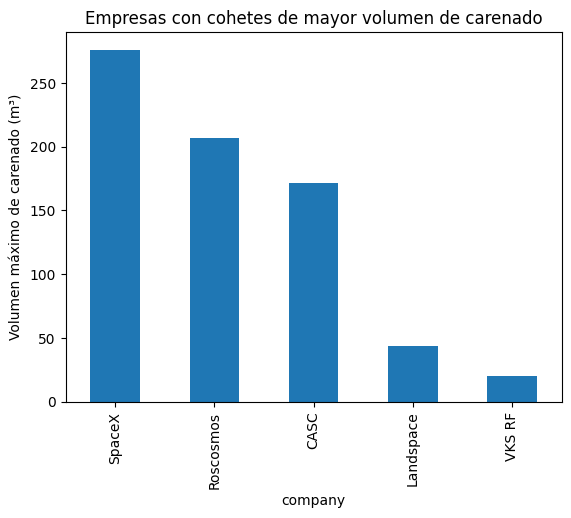

In [97]:
# Graficar el top 5 empresas por volumen de carenado
empresas_volumen.head(5).plot(kind="bar")
plt.ylabel("Volumen máximo de carenado (m³)")
plt.title("Empresas con cohetes de mayor volumen de carenado")
plt.show()

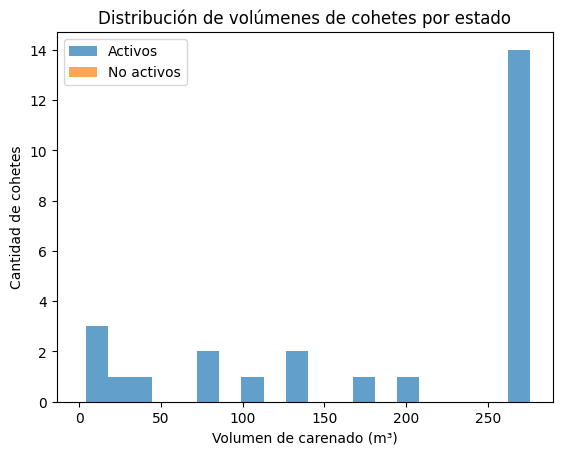

In [98]:
import matplotlib.pyplot as plt

# Filtrar por estado
volumen_activos = df[df["Status"] == "Active"]["Fairing Volume (m³)"]
volumen_no_activos = df[df["Status"] != "Active"]["Fairing Volume (m³)"]

# Graficar histogramas superpuestos
plt.hist(volumen_activos, bins=20, alpha=0.7, label="Activos")
plt.hist(volumen_no_activos, bins=20, alpha=0.7, label="No activos")
plt.xlabel("Volumen de carenado (m³)")
plt.ylabel("Cantidad de cohetes")
plt.title("Distribución de volúmenes de cohetes por estado")
plt.legend()
plt.show()